In [1]:
from utilities import *

I am in libs


In [2]:
%store -r x_scaled
%store -r Y

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled,Y,
                                test_size = 0.2, random_state = 32, stratify=Y['mortalité à un an'])

In [4]:
X_train = x_train.to_numpy().reshape(x_train.shape[0],x_train.shape[1],1)
X_test = x_test.to_numpy().reshape(x_test.shape[0],x_test.shape[1],1)

In [5]:
#converting dataset into 3d
x = x_scaled.to_numpy().reshape(x_scaled.shape[0],x_scaled.shape[1],1)

In [6]:
def feature_u(metric):
    metrics = np.array(metric)
    metric_list = [
        {"metric": me}
        for me in metrics
    ]
    a= make_union( 
        PersistenceEntropy(normalize=True), 
        NumberOfPoints(n_jobs=-1),
        *[Amplitude(**m, n_jobs=-1) for m in metric_list])
    #print("*"*50)
    #print(a)
    return a

In [7]:
# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

train = persistence.fit_transform(X_train)
test = persistence.fit_transform(X_test)

In [8]:
def tda_tranform(model):
    metrics = getMetrics()
    
    diagram_steps = [
       VietorisRipsPersistence(homology_dimensions=[0, 1, 2]),
    ]

    # Select a variety of metrics to calculate amplitudes
    metric_list = [
        {"metric": metric}
        for metric in ["bottleneck"]
    ]

    # Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
    feature_union = make_union(
        PersistenceEntropy(nan_fill_value=-1),
        NumberOfPoints(n_jobs=-1),
        *[Amplitude(**metric, n_jobs=-1) for metric in metric_list]
    )

    
    pipe = Pipeline(
        [
            ("features", feature_union),
            ("rf", model),
        ]
    )
    
    param_grid = { 'features':[feature_u(metric=metrics[i]) for i in range(len(metrics))]}

    CV = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5,scoring='f1')
    
    return CV

## RandomForest

In [9]:
tda = tda_tranform(RandomForestClassifier(oob_score=True, random_state=42)).fit(train,y_train['mortalité à un an'])

In [10]:
# training
# tda.best_score_

0.42890756302521

In [11]:
# To verify that there is only one best combination
np.where(pd.DataFrame(tda.cv_results_)['rank_test_score']==1)

(array([62], dtype=int64),)

In [12]:
print('The best combination is : ',tda.best_params_['features'].get_params()['transformer_list'])


The best combination is :  [('persistenceentropy', PersistenceEntropy(normalize=True)), ('numberofpoints', NumberOfPoints(n_jobs=-1)), ('amplitude-1', Amplitude(metric='heat', n_jobs=-1)), ('amplitude-2', Amplitude(metric='silhouette', n_jobs=-1)), ('amplitude-3', Amplitude(metric='persistence_image', n_jobs=-1))]


In [13]:
y = tda.predict(test)

Results RandomForest trainning
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Recall: 1.0
Training Precision: 1.0
Training F1-score: 1.0


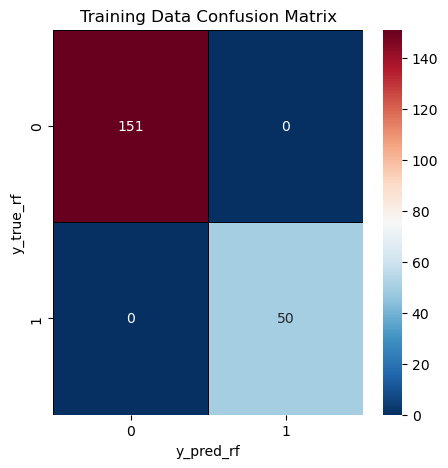

In [17]:
print("Results RandomForest trainning")
classification_results(train,y_train['mortalité à un an'],tda.predict(train),tda)

Results for Recall Optimized Multi-Layer Perceptron GSCV
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        38
           1       0.33      0.46      0.39        13

    accuracy                           0.63        51
   macro avg       0.56      0.57      0.56        51
weighted avg       0.67      0.63      0.64        51

Training Recall: 0.6842
Training Precision: 0.7879
Training F1-score: 0.7324


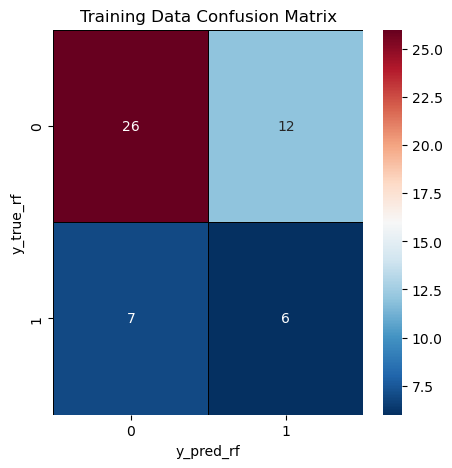

In [14]:
print("Results for RandomForest Testing")
classification_results(test,y_test['mortalité à un an'],y,tda)

## LogisticRegression

In [18]:
lr = tda_tranform(LogisticRegression()).fit(train,y_train['mortalité à un an'])

In [19]:
print('The best combination is : ',lr.best_params_['features'].get_params()['transformer_list'])


The best combination is :  [('persistenceentropy', PersistenceEntropy(normalize=True)), ('numberofpoints', NumberOfPoints(n_jobs=-1)), ('amplitude-1', Amplitude(metric='wasserstein', n_jobs=-1)), ('amplitude-2', Amplitude(metric='heat', n_jobs=-1))]


Results Logistic regression trainning
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       151
           1       0.77      0.20      0.32        50

    accuracy                           0.79       201
   macro avg       0.78      0.59      0.60       201
weighted avg       0.78      0.79      0.73       201

Training Recall: 0.9801
Training Precision: 0.7872
Training F1-score: 0.8732


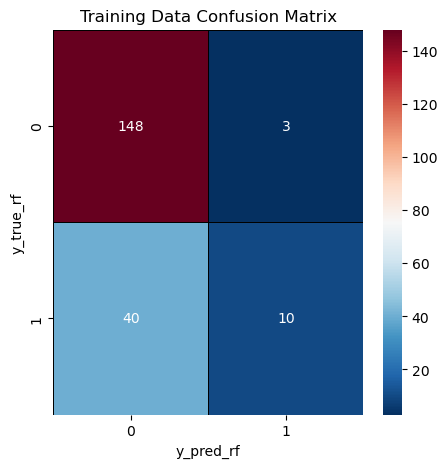

In [20]:
print("Results Logistic regression trainning")
classification_results(train,y_train['mortalité à un an'],lr.predict(train),tda)

Results Logistic regression testing
              precision    recall  f1-score   support

           0       0.77      0.87      0.81        38
           1       0.38      0.23      0.29        13

    accuracy                           0.71        51
   macro avg       0.57      0.55      0.55        51
weighted avg       0.67      0.71      0.68        51

Training Recall: 0.8684
Training Precision: 0.7674
Training F1-score: 0.8148


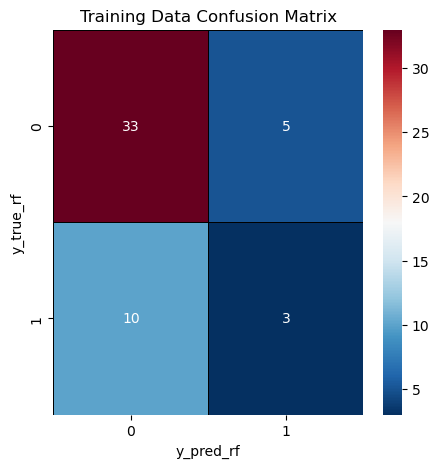

In [23]:
print("Results Logistic regression testing")
classification_results(test,y_test['mortalité à un an'],lr.predict(test),lr)

## SVC

In [24]:
svc = tda_tranform(SVC()).fit(train,y_train['mortalité à un an'])

In [25]:
print('The best combination is : ',svc.best_params_['features'].get_params()['transformer_list'])

The best combination is :  [('persistenceentropy', PersistenceEntropy(normalize=True)), ('numberofpoints', NumberOfPoints(n_jobs=-1)), ('amplitude', Amplitude(metric='bottleneck', n_jobs=-1))]


Results Support Vector Machine trainning
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       151
           1       1.00      0.04      0.08        50

    accuracy                           0.76       201
   macro avg       0.88      0.52      0.47       201
weighted avg       0.82      0.76      0.67       201

Training Recall: 1.0
Training Precision: 0.7588
Training F1-score: 0.8629


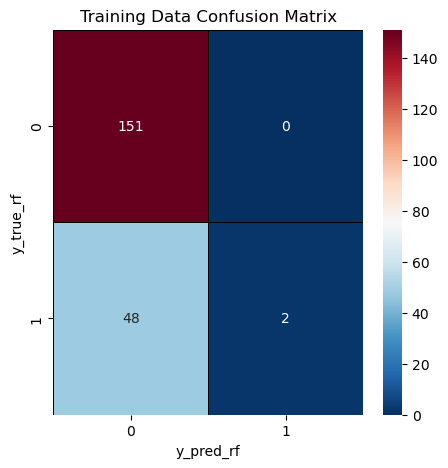

In [26]:
print("Results Support Vector Machine trainning")
classification_results(train,y_train['mortalité à un an'],svc.predict(train),tda)

Results Support Vector Machine testing
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        38
           1       1.00      0.08      0.14        13

    accuracy                           0.76        51
   macro avg       0.88      0.54      0.50        51
weighted avg       0.82      0.76      0.68        51

Training Recall: 1.0
Training Precision: 0.76
Training F1-score: 0.8636


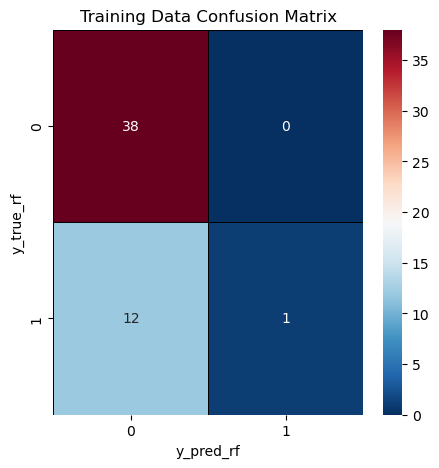

In [27]:
print("Results Support Vector Machine testing")
classification_results(test,y_test['mortalité à un an'],svc.predict(test),lr)

## MLPClassifier

In [28]:
mlp = tda_tranform(MLPClassifier()).fit(train,y_train['mortalité à un an'])

In [29]:
print('The best combination is : ',mlp.best_params_['features'].get_params()['transformer_list'])

The best combination is :  [('persistenceentropy', PersistenceEntropy(normalize=True)), ('numberofpoints', NumberOfPoints(n_jobs=-1)), ('amplitude-1', Amplitude(metric='bottleneck', n_jobs=-1)), ('amplitude-2', Amplitude(metric='wasserstein', n_jobs=-1)), ('amplitude-3', Amplitude(n_jobs=-1)), ('amplitude-4', Amplitude(metric='heat', n_jobs=-1))]


Results Multilayer perceptron trainning
              precision    recall  f1-score   support

           0       0.76      1.00      0.87       151
           1       1.00      0.06      0.11        50

    accuracy                           0.77       201
   macro avg       0.88      0.53      0.49       201
weighted avg       0.82      0.77      0.68       201

Training Recall: 1.0
Training Precision: 0.7626
Training F1-score: 0.8653


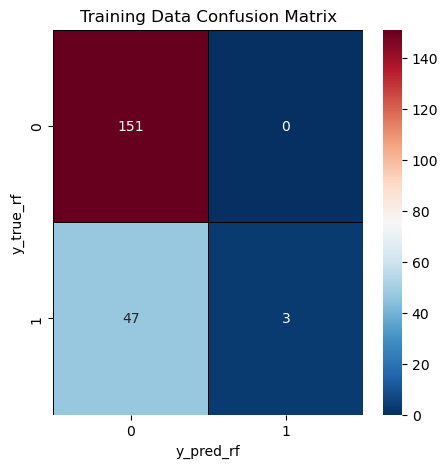

In [30]:
print("Results Multilayer perceptron trainning")
classification_results(train,y_train['mortalité à un an'],mlp.predict(train),tda)

Results Multilayer perceptron testing
              precision    recall  f1-score   support

           0       0.78      1.00      0.87        38
           1       1.00      0.15      0.27        13

    accuracy                           0.78        51
   macro avg       0.89      0.58      0.57        51
weighted avg       0.83      0.78      0.72        51

Training Recall: 1.0
Training Precision: 0.7755
Training F1-score: 0.8736


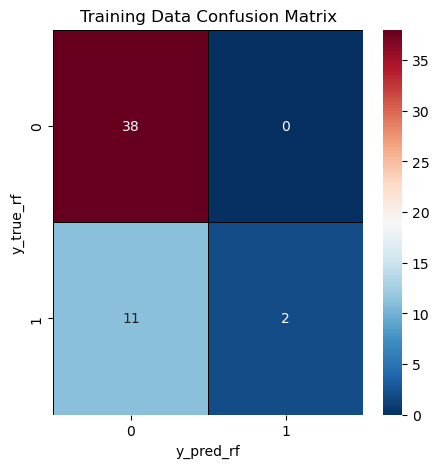

In [31]:
print("Results Multilayer perceptron testing")
classification_results(test,y_test['mortalité à un an'],mlp.predict(test),lr)

## GaussianNB

In [32]:
gnb = tda_tranform(GaussianNB()).fit(train,y_train['mortalité à un an'])

In [33]:
print('The best combination is : ',gnb.best_params_['features'].get_params()['transformer_list'])

The best combination is :  [('persistenceentropy', PersistenceEntropy(normalize=True)), ('numberofpoints', NumberOfPoints(n_jobs=-1)), ('amplitude-1', Amplitude(metric='betti', n_jobs=-1)), ('amplitude-2', Amplitude(metric='heat', n_jobs=-1))]


Results GaussianNB trainning
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       151
           1       0.50      0.40      0.44        50

    accuracy                           0.75       201
   macro avg       0.66      0.63      0.64       201
weighted avg       0.74      0.75      0.74       201

Training Recall: 0.8675
Training Precision: 0.8137
Training F1-score: 0.8397


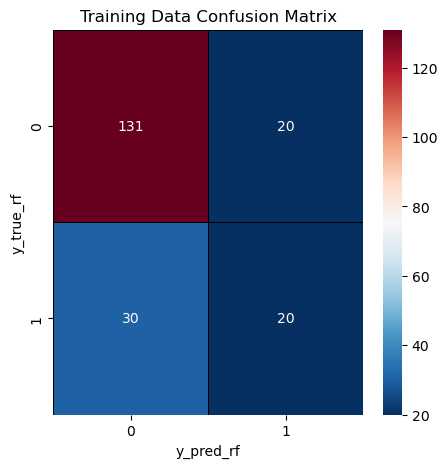

In [34]:
print("Results GaussianNB trainning")
classification_results(train,y_train['mortalité à un an'],gnb.predict(train),tda)

Results GaussianNB testing
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        38
           1       0.27      0.23      0.25        13

    accuracy                           0.65        51
   macro avg       0.51      0.51      0.51        51
weighted avg       0.63      0.65      0.64        51

Training Recall: 0.7895
Training Precision: 0.75
Training F1-score: 0.7692


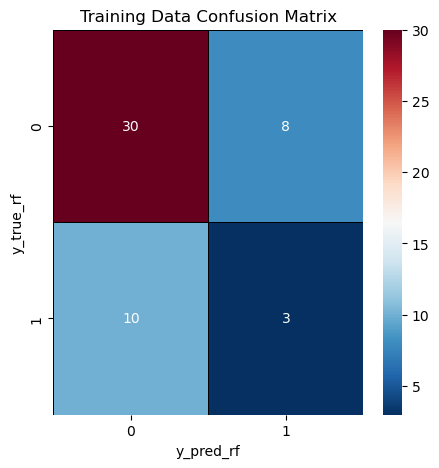

In [35]:
print("Results GaussianNB testing")
classification_results(test,y_test['mortalité à un an'],gnb.predict(test),lr)

## DecisionTreeClassifier

In [36]:
dtc = tda_tranform(DecisionTreeClassifier()).fit(train,y_train['mortalité à un an'])

In [37]:
print('The best combination is : ',dtc.best_params_['features'].get_params()['transformer_list'])

The best combination is :  [('persistenceentropy', PersistenceEntropy(normalize=True)), ('numberofpoints', NumberOfPoints(n_jobs=-1)), ('amplitude-1', Amplitude(metric='wasserstein', n_jobs=-1)), ('amplitude-2', Amplitude(metric='betti', n_jobs=-1)), ('amplitude-3', Amplitude(metric='silhouette', n_jobs=-1))]


Results DecisionTreeClassifier trainning
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Recall: 1.0
Training Precision: 1.0
Training F1-score: 1.0


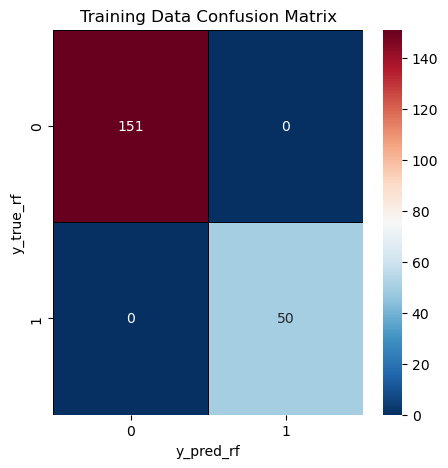

In [38]:
print("Results DecisionTreeClassifier trainning")
classification_results(train,y_train['mortalité à un an'],dtc.predict(train),tda)

Results DecisionTreeClassifier testing
              precision    recall  f1-score   support

           0       0.77      0.63      0.70        38
           1       0.30      0.46      0.36        13

    accuracy                           0.59        51
   macro avg       0.54      0.55      0.53        51
weighted avg       0.65      0.59      0.61        51

Training Recall: 0.6316
Training Precision: 0.7742
Training F1-score: 0.6957


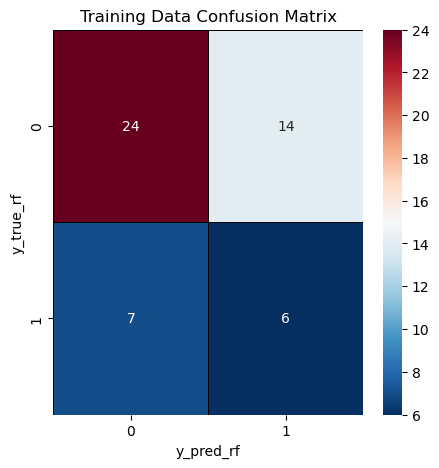

In [39]:
print("Results DecisionTreeClassifier testing")
classification_results(test,y_test['mortalité à un an'],dtc.predict(test),lr)